In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

import iqsq
from iqsq import (
    iq_cpu_naive,
    iq_cpu_opt_1,
    iq_gpu_naive,
    iq_gpu_opt_1,
    iq_gpu_opt_2,
    q_constants
)


In [2]:
scattering_factors_df = iqsq.build_scattering_factors_table(
    aff_elements_fp='GrSqf_cal_AP_Oct27/aff_elementonly.txt',
    aff_parameters_fp='GrSqf_cal_AP_Oct27/aff_parmonly.txt'
)
scattering_factors_df

,0,1,2,3,4,5,6,7,8
0,,,,,,,,,
H,0.489918,20.659300,0.262003,7.74039,0.196767,49.5519,0.049879,2.20159,0.001305
H1-,0.897661,53.136800,0.565616,15.18700,0.415815,186.5760,0.116973,3.56709,0.002389
He,0.873400,9.103700,0.630900,3.35680,0.311200,22.9276,0.178000,0.98210,0.006400
Li,1.128200,3.954600,0.750800,1.05240,0.617500,85.3905,0.465300,168.26100,0.037700
Li1+,0.696800,4.623700,0.788800,1.95570,0.341400,0.6316,0.156300,10.09530,0.016700
...,...,...,...,...,...,...,...,...,...
Pu6+,35.173600,0.473204,22.718100,2.73848,14.763500,11.5530,2.286780,20.93030,13.058200
Am,36.670600,0.483629,24.099200,3.20647,17.341500,14.3136,3.493310,102.27300,13.359200
Cm,36.648800,0.465154,24.409600,3.08997,17.399000,13.4346,4.216650,88.48340,13.288700


In [3]:
%load_ext line_profiler

In [4]:
ideal_atom_positions_df = iqsq.read_atom_positions(
    atom_positions_path="~/project/iq-on-gpu/data-20230605/5IrC_r5b.xyz",
    header=1,
    names=["x", "y", "z"],
    index_col=0,
    delim_whitespace=True
)
ideal_atom_distance_matrix_df = iqsq.build_atom_distance_matrix(ideal_atom_positions_df)

In [5]:
# in preparation for perturbing the atom positions
# find the minimum distance between atoms
ideal_atom_distance_matrix_df[ideal_atom_distance_matrix_df > 0].min().min()

1.9786553514950498

In [6]:
ideal_atom_positions_df

,x,y,z
Ir,4.514,4.516,6.228
O,5.924,5.927,6.228
O,3.103,3.106,6.228
O,3.648,5.382,7.807
O,5.380,3.650,7.807
O,3.595,5.415,4.698
O,5.414,3.596,4.697
Ir,4.505,4.505,3.159
O,5.907,5.907,3.171
O,3.103,3.103,3.216


In [7]:
# read I(q) experimental measurement
experimental_qIq_df = pd.read_table(
    filepath_or_buffer="/home/jlynch/project/iq-on-gpu/data-20230605/A_0p303V-1_modified.chi",
    header=None
)

In [8]:
experimental_qIq_df

,0,1
0,0.80836,5295.62887
1,0.81976,5172.88821
2,0.83117,5064.56519
3,0.84257,4966.40648
4,0.85398,4875.16761
...,...,...
2863,33.46305,-520.31250
2864,33.47445,-510.43750
2865,33.48586,-499.18750
2866,33.49727,-494.31250


In [9]:
experimental_qIq = experimental_qIq_df.to_numpy()

In [10]:
experimental_qIq.shape

(2868, 2)

In [11]:
experimental_qIq[(experimental_qIq[:, 1] > 0.0)].shape

(1984, 2)

In [12]:
pos_experimental_qIq = experimental_qIq[:1984, :]

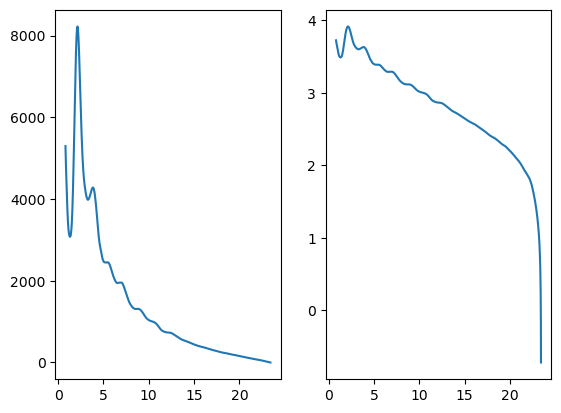

In [13]:
f1 = plt.figure()
ax1 = f1.add_subplot(1, 2, 1)
ax2 = f1.add_subplot(1, 2, 2)
ax1.plot(pos_experimental_qIq[:, 0], pos_experimental_qIq[:,1])
ax2.plot(pos_experimental_qIq[:, 0],np.log10(pos_experimental_qIq[:,1]))

In [14]:
ideal_qIq = iq_gpu_opt_2.calculate_iq_qrange(
    scattering_factors_df=scattering_factors_df,
    atom_distance_matrix_df=ideal_atom_distance_matrix_df,
    q_range=pos_experimental_qIq[:, 0]
)

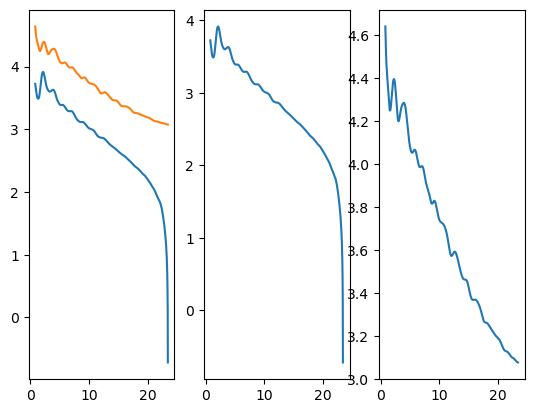

In [15]:
f2 = plt.figure()
ax2_1 = f2.add_subplot(1, 3, 1)
ax2_2 = f2.add_subplot(1, 3, 2)
ax2_3 = f2.add_subplot(1, 3, 3)
ax2_1.plot(pos_experimental_qIq[:, 0],np.log10(pos_experimental_qIq[:,1]))
ax2_1.plot(ideal_qIq[:, 0],np.log10(ideal_qIq[:,1]))
ax2_2.plot(pos_experimental_qIq[:, 0],np.log10(pos_experimental_qIq[:,1]))
ax2_3.plot(ideal_qIq[:, 0],np.log10(ideal_qIq[:,1]))

In [16]:
ideal_qIq[ideal_qIq[:, 0] < 12.0].shape

(982, 2)

In [17]:
trimmed_experimental_qIq = pos_experimental_qIq[:982]
trimmed_ideal_qIq = ideal_qIq[:982]

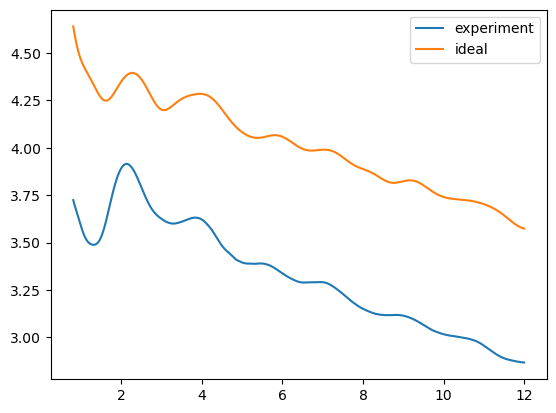

In [39]:
f3 = plt.figure()
ax3 = f3.add_subplot(1, 1, 1)
exp_line = ax3.plot(trimmed_experimental_qIq[:, 0], np.log10(trimmed_experimental_qIq[:,1]), label="experiment")
ideal_line = ax3.plot(trimmed_ideal_qIq[:, 0],np.log10(trimmed_ideal_qIq[:,1]), label="ideal")
ax3.legend()

In [30]:
# find optimal? overlap?
def overlap_cost(x, *args):
    # shift the experimental I(q) toward the ideal I(q)
    shifted_log10_trimmed_experimental_qIq = np.log10(trimmed_experimental_qIq[:,1]) + x
    #print(shifted_log10_trimmed_experimental_qIq)
    cost = np.sqrt(
        np.sum(
            (shifted_log10_trimmed_experimental_qIq - np.log10(trimmed_ideal_qIq[:, 1]))**2
        )
    )
    return cost

In [60]:
overlap_cost(x=0.695)

2.4807151472582523

In [57]:
np.mean(np.log10(trimmed_experimental_qIq[:, 1]))

3.3237894904198884

In [58]:
np.mean(np.log10(trimmed_ideal_qIq[:, 1]))

4.018925226506175

In [59]:
np.abs(np.mean(np.log10(trimmed_experimental_qIq[:, 1])) - np.mean(np.log10(trimmed_ideal_qIq[:, 1])))

0.6951357360862866

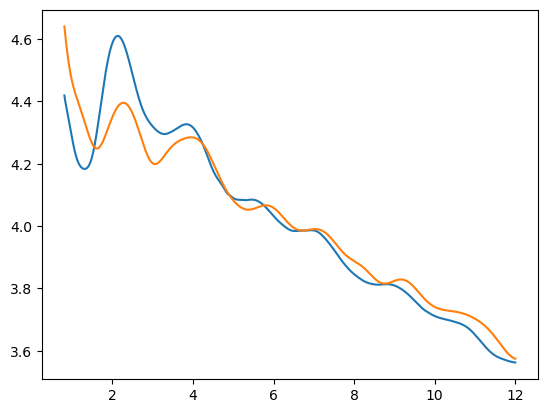

In [61]:
f4 = plt.figure()
ax4 = f4.add_subplot(1, 1, 1)
ax4.plot(trimmed_experimental_qIq[:, 0], 0.695 + np.log10(trimmed_experimental_qIq[:,1]))
ax4.plot(trimmed_ideal_qIq[:, 0], np.log10(trimmed_ideal_qIq[:,1]))

In [79]:
from scipy.spatial.distance import euclidean

def Iq_cost(x, *args, return_qIq=False):
    _atom_positions_deltas = np.reshape(x, ideal_atom_positions_df.shape)
    _atom_positions_df = ideal_atom_positions_df + _atom_positions_deltas
    _atom_distance_matrix_df = iqsq.build_atom_distance_matrix(_atom_positions_df)
    _qIq = iq_gpu_opt_2.calculate_iq_qrange(
        scattering_factors_df=scattering_factors_df,
        atom_distance_matrix_df=_atom_distance_matrix_df,
        q_range=trimmed_experimental_qIq[:, 0]
    )

    #cost = euclidean(np.log(_qIq[:,1]), np.log(qIq[:,1]))
    cost = euclidean(
        np.log10(_qIq[:,1]),
        (0.695 + np.log10(trimmed_experimental_qIq[:,1]))
    )
    #print(f"Iq_cost: {cost}")

    if return_qIq:
        return cost, _qIq
    else:
        return cost

In [94]:
def display_best_cost(xk, convergence):
    cost, qIq = Iq_cost(xk, return_qIq=True)
    # this is displayed when disp=True
    #print(f"best cost so far: {cost}")
    plt.plot(qIq[:,0],np.log10(qIq[:,1]), label="fit")
    plt.plot(trimmed_experimental_qIq[:, 0], 0.695 + np.log10(trimmed_experimental_qIq[:,1]), label="experiment")
    #plt.legend()

parameter count: 81
differential_evolution step 1: f(x)= 2.25769
differential_evolution step 2: f(x)= 2.24322
differential_evolution step 3: f(x)= 2.22453
differential_evolution step 4: f(x)= 2.20835
differential_evolution step 5: f(x)= 2.20835
differential_evolution step 6: f(x)= 2.20835
differential_evolution step 7: f(x)= 2.20835
differential_evolution step 8: f(x)= 2.20835
differential_evolution step 9: f(x)= 2.19751
differential_evolution step 10: f(x)= 2.19751
differential_evolution step 11: f(x)= 2.19751
differential_evolution step 12: f(x)= 2.19751


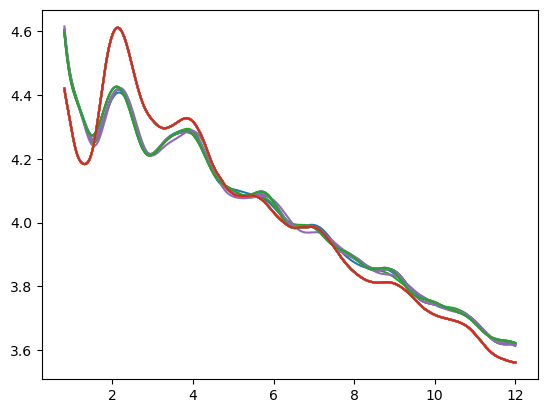

In [95]:
from scipy.optimize import differential_evolution

parameter_count = ideal_atom_positions_df.shape[0] * ideal_atom_positions_df.shape[1]
print(f"parameter count: {parameter_count}")
de_result = differential_evolution(
    func=Iq_cost,
    bounds=[(-0.25, 0.25) for i in range(parameter_count)],
    popsize=2,
    polish=False,
    disp=True,
    callback=display_best_cost,
    maxiter=1000
)

In [82]:
de_result

     fun: 2.19035036867192
 message: 'Optimization terminated successfully.'
    nfev: 2592
     nit: 15
 success: True
       x: array([ 0.0998275 ,  0.06507228,  0.2265852 ,  0.16762976,  0.00401831,
       -0.00651959,  0.00044136, -0.24824617, -0.20556782, -0.04789481,
        0.23767928,  0.24853905,  0.23762409,  0.07134844,  0.02038325,
        0.04640926,  0.18521483, -0.0741101 ,  0.22362022, -0.02726966,
       -0.10183354,  0.11422954, -0.0398163 ,  0.04829541,  0.10572541,
        0.18106103,  0.17040782, -0.11400574,  0.13971887, -0.07266679,
       -0.03233599,  0.08725752, -0.21666749, -0.16652695,  0.15985846,
       -0.05634338, -0.22714133,  0.04187199, -0.2440731 ,  0.01371385,
        0.0800828 , -0.11074539,  0.15403487, -0.01111643, -0.086227  ,
       -0.08004471,  0.16448106,  0.1666802 , -0.0134134 , -0.06011031,
        0.14289574, -0.01853286,  0.06177349,  0.02766581,  0.04402292,
       -0.0058326 ,  0.24911922, -0.19439246,  0.23349307,  0.03895928,
      

In [86]:
ideal_atom_positions = ideal_atom_positions_df.to_numpy()
de_position_offsets = np.reshape(de_result.x, atom_positions.shape)
de_atom_positions = ideal_atom_positions + de_position_offsets

In [87]:
plt.ion()

In [89]:
def plot_Iq(_ax, _atom_distance_matrix_df):
    _qIq = iq_gpu_opt_2.calculate_iq_qrange(
        scattering_factors_df=scattering_factors_df,
        atom_distance_matrix_df=_atom_distance_matrix_df,
        q_range=trimmed_experimental_qIq[:, 0]
    )

    _ax.plot(_qIq[:,0],np.log10(_qIq[:,1]))

    return _qIq

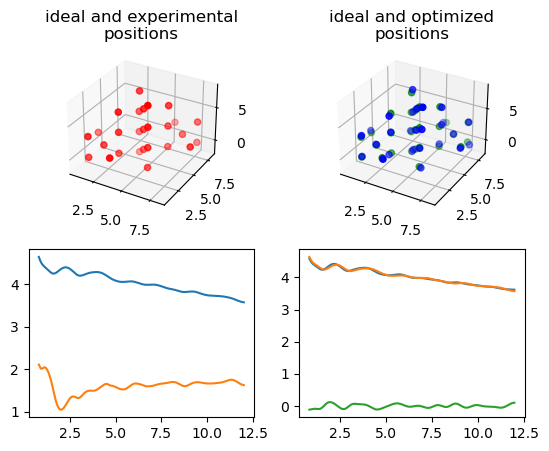

In [93]:
perturbed_fig = plt.figure()
a3 = perturbed_fig.add_subplot(2, 2, 1, projection='3d')
a3.set_title("ideal and experimental\npositions")
a3.scatter(
    ideal_atom_positions[:, 0],
    ideal_atom_positions[:, 1],
    ideal_atom_positions[:, 2],
    color='r'
)
# a3.scatter(
#     atom_positions[:, 0],
#     atom_positions[:, 1],
#     atom_positions[:, 2],
#     color='g'
# )

ax_Iq = perturbed_fig.add_subplot(2, 2, 3)
ideal_qIq = plot_Iq(ax_Iq, ideal_atom_distance_matrix_df)
#experimental_qIq = plot_Iq(ax_Iq, experimental_atom_distance_matrix_df)
ax_Iq.plot(trimmed_ideal_qIq[:, 0], np.log(trimmed_ideal_qIq[:, 1]) - np.log(trimmed_experimental_qIq[:, 1]))

de_a3 = perturbed_fig.add_subplot(2, 2, 2, projection='3d')
de_a3.set_title("ideal and optimized\npositions")
de_a3.scatter(
    de_atom_positions[:, 0],
    de_atom_positions[:, 1],
    de_atom_positions[:, 2],
    color='b'
)
de_a3.scatter(
    ideal_atom_positions[:, 0],
    ideal_atom_positions[:, 1],
    ideal_atom_positions[:, 2],
    color='g'
)


de_ax_Iq = perturbed_fig.add_subplot(2, 2, 4)

de_atom_positions_df = ideal_atom_positions_df + de_position_offsets
de_atom_distance_matrix_df = iqsq.build_atom_distance_matrix(de_atom_positions_df)

de_qIq = plot_Iq(de_ax_Iq, de_atom_distance_matrix_df)
ideal_qIq = plot_Iq(de_ax_Iq, ideal_atom_distance_matrix_df)
de_ax_Iq.plot(ideal_qIq[:, 0], np.log(de_qIq[:, 1]) - np.log(ideal_qIq[:, 1]))
